# SPISEA: Making a Cluster with BD Candidates

This is a document to generate a synthetic cluster in SPISEA with the addition of brown dwarf candidates. It will follow the Quick Start Guide closely, but with changes due to a lower mass limit and ability to consider smaller objects.

In [39]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

### 1: Making an Isochrone Object for our Cluster

In [38]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Specify the directory we want the output isochrone
# table saved in. If the directory does not already exist,
# SPISEA will create it.
iso_dir = 'isochrones/'

# Make IsochronePhot object. Note that this will take a minute or two, 
# unless the isochrone has been generated previously.
#
# Note that this is not show all of the user options 
# for IsochronePhot. See docs for complete list of options.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)

Changing to logg=4.00 for T= 32651 logg=3.99
Changing to logg=4.00 for T= 32840 logg=3.98
Changing to logg=4.00 for T= 33037 logg=3.97
Changing to logg=4.00 for T= 33144 logg=3.96
Changing to logg=4.00 for T= 33205 logg=3.95
Changing to logg=4.00 for T= 33358 logg=3.94
Changing to logg=4.00 for T= 33504 logg=3.93
Changing to logg=4.00 for T= 33651 logg=3.91
Changing to logg=4.00 for T= 33713 logg=3.91
Changing to logg=4.00 for T= 33775 logg=3.90
Changing to logg=4.00 for T= 33892 logg=3.89
Changing to logg=4.00 for T= 34002 logg=3.87
Changing to logg=4.00 for T= 34111 logg=3.86
Changing to logg=4.00 for T= 34182 logg=3.85
Changing to logg=4.00 for T= 34222 logg=3.85
Changing to logg=4.00 for T= 34332 logg=3.83
Changing to logg=4.00 for T= 34443 logg=3.82
Changing to logg=4.00 for T= 34546 logg=3.81
Changing to logg=4.00 for T= 34658 logg=3.80
Changing to logg=4.00 for T= 34674 logg=3.80
Changing to logg=4.00 for T= 34746 logg=3.79
Changing to logg=4.00 for T= 34842 logg=3.78
Changing t

In [ ]:
# The stars in the isochrone and associated properties  
# are stored in an astropy table called "points" 
# within the IsochronePhot object. 
print(my_iso.points)

In [ ]:
# Example case:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

In [ ]:
# Make a color-magnitude diagram from the isochrone
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### 2: Bringing in an IMF

In [ ]:
# Make multiplicity object Here, we use the MultiplicityUnresolved object, 
# based on Lu+13. This means that star systems will be unresolved, i.e., 
# that all components of a star system are combined into a single "star" in the cluster
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

my_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)

### 3: Generating Cluster

In [ ]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

In [ ]:
# Look at star systems table
print(cluster.star_systems)

In [ ]:
# The companions table is accessed in a similar way
print(cluster.companions)

In [ ]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

In [ ]:
print("minimum primary mass: " + str(np.min(clust['mass'])))
print("minimum companion mass: " + str(np.min(cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(clust['mass'])))
print("maximum companion mass: " + str(np.max(cluster.companions['mass'])))

### Creating a histogram to compare Weidner Kroupa and Muzic

In [ ]:
#generate clusters for each class
w_imf = imf.Weidner_Kroupa_2004(multiplicity=imf_multi)
m_imf = imf.Muzic_2017(multiplicity=imf_multi)

In [ ]:
# Define total cluster mass
mass = 10**5.

# Make cluster objects for each
w_cluster = synthetic.ResolvedCluster(my_iso, w_imf, mass)
m_cluster = synthetic.ResolvedCluster(my_iso, m_imf, mass)

#### Comparing Weidner Kroupa and Muzic clusters data

In [ ]:
#show total numbers for each cluster
print("primary masses in Weidner Kroupa cluster: " + str(len(w_cluster.star_systems)))
print("companion masses in Weidner Kroupa cluster: " + str(len(w_cluster.companions)))
print("primary masses in Muzic cluster: " + str(len(m_cluster.star_systems)))
print("companion masses in Muzic cluster: " + str(len(m_cluster.companions)))

In [ ]:
#Comparing max/min primary/companion masses
#Weidner Kroupa
print('\033[1m' + "Weidner Kroupa" + '\033[0m')
print("minimum primary mass: " + str(np.min(w_cluster.star_systems['mass'])))
print("minimum companion mass: " + str(np.min(w_cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(w_cluster.star_systems['mass'])))
print("maximum companion mass: " + str(np.max(w_cluster.companions['mass'])))
print('\n')

#Muzic
print('\033[1m' + "Muzic" + '\033[0m')
print("minimum primary mass: " + str(np.min(m_cluster.star_systems['mass'])))
print("minimum companion mass: " + str(np.min(m_cluster.companions['mass'])))
print("maximum primary mass: " + str(np.max(m_cluster.star_systems['mass'])))
print("maximum companion mass: " + str(np.max(m_cluster.companions['mass'])))

In [ ]:
#compare total cluster masses
#create combined arrays of primary/companion masses
all_m_masses = np.concatenate((m_cluster.star_systems['mass'], m_cluster.companions['mass']))
all_w_masses = np.concatenate((w_cluster.star_systems['mass'], w_cluster.companions['mass']))

#find total of added masses
print("total mass of WD cluster: " + str(np.sum(all_w_masses)))
print("total mass of M cluster: " + str(np.sum(all_m_masses)))

In [ ]:
#define mass range of histogram
bin_edges = [0.01, 0.08, 0.5, 1, 2]

#setting up subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
plt.subplots_adjust(hspace=0.5, wspace=0.75)

#create histograms to compare
counts_m, edges_m, _ = ax[0].hist(all_m_masses, bins=bin_edges, alpha=0.5, label='Muzic_2017', color='blue', edgecolor='black', histtype='bar')
counts_w, edges_w, _ = ax[1].hist(all_w_masses, bins=bin_edges, alpha=0.5, label='Weidner_Kroupa_2004', color='red', edgecolor='black', histtype='bar')

#compute bin centers
bin_centers_m = (edges_m[:-1] + edges_m[1:]) / 2
bin_centers_w = (edges_w[:-1] + edges_w[1:]) / 2

#generate x values for the broken power law curve
x_fit_m = np.linspace(bin_centers_m.min(), bin_centers_m.max(), 100)
x_fit_w = np.linspace(bin_centers_w.min(), bin_centers_w.max(), 100)



#labels and legend
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Number of Stars')
plt.title('Comparison of Stellar Mass Distributions')
plt.legend()
plt.show()

## Generating a cluster with compound objects (using an IFMR)
This is before code is modified to allow for brown dwarves

In [30]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only 1 filter
my_ifmr = ifmr.IFMR_Raithel18()
my_iso = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MergedBaraffePisaEkstromParsec(),
                                      filters=filt_list)

In [31]:
# Create IMF objects  
imf_multi = multiplicity.MultiplicityUnresolved()
massLimits = np.array([0.01, 0.08, 0.5, 1, np.inf])
powers = np.array([-0.3, -1.3, -2.3, -2.35])
k_imf = imf.IMF_broken_powerlaw(massLimits, powers, multiplicity=imf_multi)

In [32]:
# Make clusters
cluster_mass = 10**6
k_cluster = synthetic.ResolvedCluster(my_iso, k_imf, cluster_mass, ifmr=my_ifmr)

# Get outputs
k_out = k_cluster.star_systems
k_comp = k_cluster.companions

Found 580447 stars out of mass range
Found 113559 companions out of stellar mass range


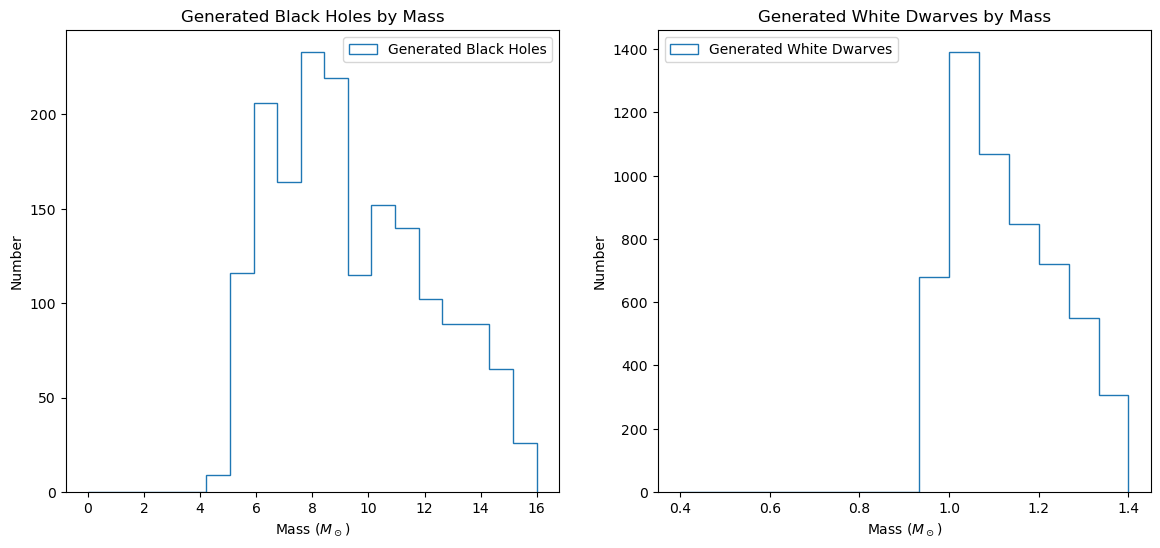

In [33]:
# Locate BHs, NSs and WDs
p_bh = np.where(k_out['phase'] == 103)[0]
c_bh = np.where(k_comp['phase'] == 103)[0]
k_bh = np.concatenate([p_bh, c_bh])
p_ns = np.where(k_out['phase'] == 102)[0]
c_ns = np.where(k_comp['phase'] == 102)[0]
k_ns = np.concatenate([p_ns, c_ns])
p_wd = np.where(k_out['phase'] == 101)[0]
c_wd = np.where(k_comp['phase'] == 101)[0]
k_wd = np.concatenate([p_wd, c_wd])

# Plot on histograms
bh_bins = np.linspace(0.01, 16, 20)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(k_out[p_bh]['mass_current'], histtype = 'step',
        bins = bh_bins, label = 'Generated Black Holes')
plt.title("Generated Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(k_out[p_wd]['mass_current'], histtype = 'step',
        bins = wd_bins, label = 'Generated White Dwarves')
plt.title("Generated White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

plt.show()

In [40]:
all_masses = np.concatenate([k_out['mass'], k_comp['mass']])
tot_mass = np.sum(all_masses)
print(tot_mass)
print(np.min(k_out[p_wd]['mass']))

831012.4509070338
5.311329909891375


In [20]:
print(np.min(k_out['mass']))
print(np.min(k_comp['mass']))

0.0700003309744075
0.010000236016655941


In [21]:
print("Current smallest mass of generated black holes: " + str(np.min(k_out[k_bh]['mass_current'])))
print("Current largest mass of generated black holes: " + str(np.max(k_out[k_bh]['mass_current'])))

Current smallest mass of generated black holes: 0.07006468311672817
Current largest mass of generated black holes: 15.65838834836072


In [ ]:
print('The cluster table contains these columns: {0}'.format(k_cluster.star_systems.keys()))

In [22]:
print(k_out[p_bh])

       mass        isMultiple ...     m_hst_f153m     N_companions
------------------ ---------- ... ------------------- ------------
34.858558890643366       True ...                 nan            1
 24.21988253820487       True ... 0.19920518920036126            1
 53.76008089560359       True ... -0.2181337523917536            4
15.882675891462688       True ...  -1.810589141056601            2
 57.37043948819449       True ...                 nan            3
31.414432201808793       True ...                 nan            1
22.819575828477465       True ...  1.0957723191576627            5
               ...        ... ...                 ...          ...
23.712544384283426       True ...  1.6681099957862053            1
 52.89729960707116       True ...  1.3625884002383177            3
 82.84997226207857       True ...                 nan            2
 32.27796062878089       True ... 0.43046734619105526            3
 26.92983956402475       True ...                 nan         

In [23]:
print(k_out[p_bh]['mass'], k_out[p_bh]['mass_current'])

       mass       
------------------
34.858558890643366
 24.21988253820487
 53.76008089560359
15.882675891462688
 57.37043948819449
31.414432201808793
22.819575828477465
               ...
23.712544384283426
 52.89729960707116
 82.84997226207857
 32.27796062878089
 26.92983956402475
 27.13236574281697
  36.6006664768621
Length = 1671 rows    mass_current   
------------------
12.446576185012097
  8.78166110167993
 8.806507411947209
 5.424709536731119
 7.981409529281804
11.216283709433917
 8.283995574428168
               ...
 8.603336271797449
 9.056339719938071
 6.152701918097497
11.515219186451843
 9.707197419320156
 9.775168357448042
13.119673398892417
Length = 1671 rows


In [24]:
print("Initial mass of smallest generated black hole: " + str(np.min(k_out[p_bh]['mass'])))
print("Initial mass of largest generated black hole: " + str(np.max(k_out[p_bh]['mass'])))

Initial mass of smallest generated black hole: 15.000468103060483
Initial mass of largest generated black hole: 117.48601718195576


In [25]:
print("Initial mass of smallest generated comp black hole: " + str(np.min(k_comp[c_bh]['mass'])))
print("Initial mass of largest generated comp black hole: " + str(np.max(k_comp[c_bh]['mass'])))

Initial mass of smallest generated comp black hole: 15.037154672016358
Initial mass of largest generated comp black hole: 111.30489194158751


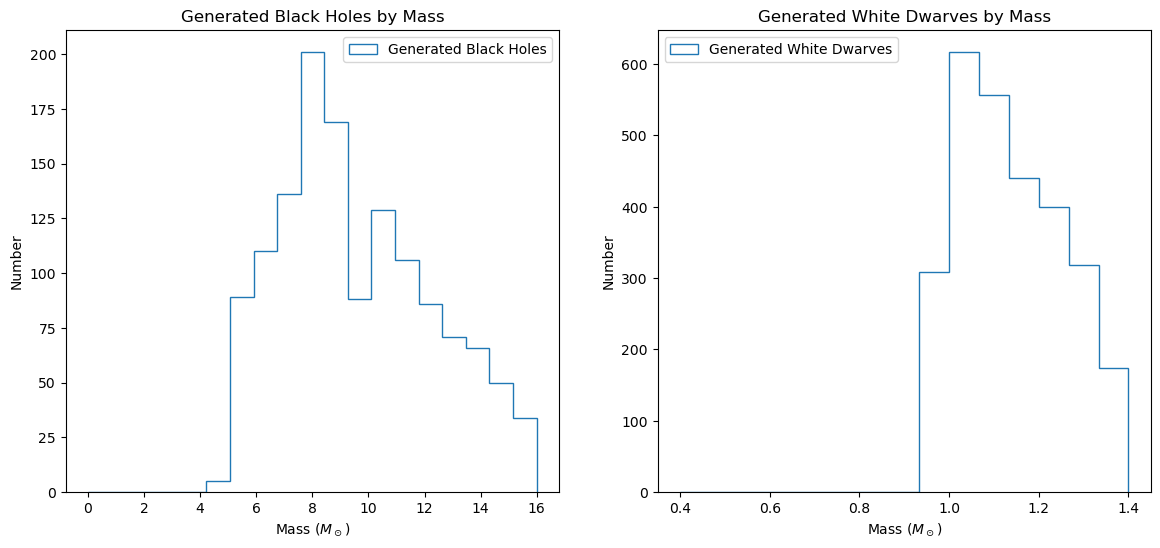

In [26]:
# Plot on histograms
bh_bins = np.linspace(0.01, 16, 20)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(k_comp[c_bh]['mass_current'], histtype = 'step',
        bins = bh_bins, label = 'Generated Black Holes')
plt.title("Generated Black Holes by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(k_comp[c_wd]['mass_current'], histtype = 'step',
        bins = wd_bins, label = 'Generated White Dwarves')
plt.title("Generated White Dwarves by Mass")
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

plt.show()

In [28]:
print(np.min(k_comp[c_wd]['mass_current']))

0.9729527582037262


## New Cluster after addition of BD criterion

In [36]:
#locate brown dwarfs
p_bd = np.where(k_out['phase'] == 99)[0]
c_bd = np.where(k_comp['phase'] == 99)[0]